<a href="https://colab.research.google.com/github/benjmcarthur/deep-learning/blob/master/sentiment-analysis/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [0]:
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [0]:
using Pkg

Pkg.add(Pkg.PackageSpec(;name="CuArrays", version=v"1.3.0"))
Pkg.add(Pkg.PackageSpec(;name="Flux", version=v"0.9.0"))

pkg"add MLDatasets"
#pkg"add ImageMagick"
#pkg"add Images"
pkg"add Embeddings"
pkg"add Plots"
pkg"precompile"

using CuArrays
using Embeddings
#using ImageMagick
#using Images
using Flux
using MLDatasets
using Plots

using LinearAlgebra
using Random

## Stanford Sentiment Treebank ###

In [0]:
run(`curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip`)
run(`unzip -q -o -d /tmp /tmp/trainDevTestTrees_PTB.zip`)
run(`rm -f /tmp/trainDevTestTrees_PTB.zip`)

nothing

In [0]:
function loadsst(path)
    xs = Array{String}[]
    ys = Int[]
    open(path) do file
        # Quick, dirty, and improper S-expression parsing.
        for line in eachline(file)
            soup = split(line)
            push!(ys, parse(Int, lstrip(first(soup), '(')))
            tokens = String[]
            for chunk in soup[2:end]
                endswith(chunk, ")") || continue
                push!(tokens, rstrip(chunk, ')'))
            end
            push!(xs, tokens)
        end
    end
    xs, ys
end

ssttrainxs, ssttrainys = loadsst("/tmp/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("/tmp/trees/dev.txt")
ssttestxs, ssttestys   = loadsst("/tmp/trees/test.txt")

nothing

In [0]:
for _ in 1:16
    i = rand(1:length(ssttrainxs))
    println("$(ssttrainys[i]): $(join(ssttrainxs[i], ' '))")
end

2: Bearable .
1: The re - enactments , however fascinating they may be as history , are too crude to serve the work especially well .
2: A mess , but it 's a sincere mess .
2: aside from showing us in explicit detail how difficult it is to win over the two-drink-minimum crowd , there 's little to be learned from watching ` Comedian '
2: This is mostly well-constructed fluff , which is all it seems intended to be .
4: It sends you away a believer again and quite cheered at just that .
2: What a vast enterprise has been marshaled in the service of such a minute idea .
1: The holes in this film remain agape -- holes punched through by an inconsistent , meandering , and sometimes dry plot .
1: One Hour Photo may seem disappointing in its generalities , but it 's the little nuances that perhaps had to escape from director Mark Romanek 's self-conscious scrutiny to happen , that finally get under your skin .
1: Although it starts off so bad that you feel like running out screaming , it event

## Pre-Processing

Load the data, and convert into the correct format for processing in the model.

Remove stopwords from each review

In [0]:
function filterCriteria(word)
    # Modified from NLTK's list found at https://gist.github.com/sebleier/554280
    stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "you're", "you've", "you'll", "you'd", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's", "her", "hers", "herself", "it", "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "that'll", "these", "those", "am", "is", "are", "was", "were", "be", "been", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"]
    append!(stopwords, [",", ".", "--", "'d", "``", "''", "`", "'","...", "?",":","it"])                   
    return word ∉ stopwords
end
    

function removeStopwords(data)
    processedData = Array{Array{String}}(undef, 0)
    for review in data
        push!(processedData, filter(filterCriteria, review))
    end
    return processedData
end

ssttrainxs = removeStopwords(ssttrainxs)
sstvalidxs = removeStopwords(sstvalidxs)
ssttestxs  = removeStopwords(ssttestxs);


Note that this cell will require the user to approve the download of the dataset.

In [0]:
using Embeddings
const w2v         = load_embeddings(Word2Vec)
const token2index = Dict(token => i for (i, token) in enumerate(w2v.vocab))
function embedding(token)
    # If a token is not in our vocabulary, we use “UNK” to represent it.
    token = token in w2v.vocab ? token : "UNK"
    w2v.embeddings[:, token2index[token]]
end

nothing

tcmalloc: large alloc 3600007168 bytes == 0xca1e000 @  0x7fc8da3bfb6b 0x7fc8da3df379 0x7fc8d9cd25ec 0x7fc8d9c9c42b 0x7fc8b324b447 0x7fc8b324a3dc 0x7fc8d9c7fb59 0x7fc8b3249f38 0x7fc8b3249c90 0x7fc8b3249d78 0x7fc8b3244fe9 0x7fc8b32450ab 0x7fc8b3244d8a 0x7fc8d9de8f10 0x7fc8d9de8c39 0x7fc8d9de95bc 0x7fc8d9de9d3f 0x7fc8d9c9596c 0x7fc8d9dea80d 0x7fc8d9cb4ffc 0x7fc8d9c908e0 0x7fc8b3202b8f 0x7fc8b32001dd 0x7fc8d9c7f0d6 0x7fc8d9c8d846 0x7fc8d9c8dea2 0x7fc8c7b9e3e9 0x7fc8c7b9f104 0x7fc8d9c7f0d6 0x7fc8d9c9ae7b (nil)


Convert each review into a set of 300-length vectors using the Word2Vec embeddings, then into batches of the correct dimensions.

In [0]:
# Converts the raw data into batches
function generateDataBatch(data::Array{Array{String}}, batchsize::Int)
    # List of batches of size batchsize
    # Each batch is 300 x batchsize x n_words
    numBatches = Int(ceil(length(data)/batchsize))
    encodedData = Array{Array{Float64,3}}(undef,numBatches)
    i = 1

    # For each batch
    for b in 1:numBatches
        thisbatchsize = min(i+batchsize-1,length(data))-i+1
        batch = zeros(300, thisbatchsize, 60)
        n = 1
        print(b, "/", numBatches,".. ")
        
        # For each review in the batch
        for r in i:min(i+batchsize-1,length(data))
            # For each word
            for w in 60:-1:(60-length(data[r])+1)
               batch[:,n,w] = embedding(data[r][60-w+1])
            end
            n += 1
        end  
        i = min(i+batchsize,length(data))
        # Create batch
        encodedData[b] = batch
    end
    println(" ")
    return encodedData
end


function generateLabelsBatch(data, batchsize)
    n = 1
    encodedLabels = []
    numBatches = Int(ceil(length(data)/batchsize))
    for i in 1:numBatches
        print(i, "/", numBatches,".. ")
        batch = Flux.onehotbatch(data[n:min(n+batchsize-1,length(data))], [0, 1, 2, 3, 4])
        push!(encodedLabels, batch)
        n = min(n+batchsize,length(data))
    end
    println(" ")
    return encodedLabels
end

generateLabelsBatch (generic function with 1 method)

In [0]:
# Convert the data into the correct format and load onto the GPU
batchsize = 500
train_xs = gpu.(generateDataBatch(ssttrainxs, batchsize))
val_xs = gpu.(generateDataBatch(sstvalidxs, batchsize))
test_xs = gpu.(generateDataBatch(ssttestxs, batchsize))

train_ys = gpu.(generateLabelsBatch(ssttrainys, batchsize))
val_ys = gpu.(generateLabelsBatch(sstvalidys, batchsize))
test_ys = gpu.(generateLabelsBatch(ssttestys, batchsize));

1/18.. 2/18.. 3/18.. 4/18.. 5/18.. 6/18.. 7/18.. 8/18.. 9/18.. 10/18.. 11/18.. 12/18.. 13/18.. 14/18.. 15/18.. 16/18.. 17/18.. 18/18..  
1/3.. 2/3.. 3/3..  
1/5.. 2/5.. 3/5.. 4/5.. 5/5..  
1/18.. 2/18.. 3/18.. 4/18.. 5/18.. 6/18.. 7/18.. 8/18.. 9/18.. 10/18.. 11/18.. 12/18.. 13/18.. 14/18.. 15/18.. 16/18.. 17/18.. 18/18..  
1/3.. 2/3.. 3/3..  
1/5.. 2/5.. 3/5.. 4/5.. 5/5..  


## 5.1 Implement a Recurrent Neural Network model

*Implement a recurrent neural network model which encodes a sequence of words into inputs to a multi-layer perceptron with a cross-entropy loss for the Stanford Sentiment Treebank data.*

The neural network model in this question uses a two-stage sequence to encode and then classify movie reviews by their ratings.

* **Accumulator**: this is a LSTM cell which is fed the sequence of words, in order. The final output of the LSTM is then fed into the classifier.
* **Classifier**: a MLP which takes the final output of the Accumulator and classifies it into one of the five ratings.


In [0]:
using Flux

# Accumulator layer takes 1 word and re-codes it with respect to the previous memory
# Classifier layer classifies the encoded word into a rating

# Set up model
accumulator = LSTM(300,120) |> gpu
classifier = Chain( Dense(120,120, leakyrelu),
                    Dense(120, 5, leakyrelu),
                    softmax) |> gpu
model = Chain(accumulator, classifier)

#Loss function
function loss(xbatch, ybatch)
    n_words = size(xbatch)[3]
    Flux.reset!(accumulator)
    for w in 1:n_words-1
        accumulator(xbatch[:,:,w])
    end
    l = Flux.crossentropy(classifier(accumulator(xbatch[:,:,n_words])), ybatch)
    return l/size(xbatch)[2]
end

loss (generic function with 1 method)

## 5.2 Explore model variants



### 5.2.1 Recurrent Units

Three types of recurrent units were tested, each with the same MLP classifier:
* LSTM
* GRU
* RNN

The table below summarises the results:

|                      | LSTM    | GRU     | RNN     |
|----------------------|---------|---------|---------|
| Best validation loss | 0.00583 | 0.00592 | 0.00641 |

The plots of the validation loss vs epochs during training showed that:
* The GRU learned quickly but was prone to overfitting early
* The RNN did not learn at all, compared to the LSTM or the GRU.

Based on this analysis, the LSTM was the best recurrent cell to continue with. 

### 5.2.2 MLP Size

Various permutations of the number and dimensions of layers were trialled. The table below summarises the results.


|  MLP Structure | Validation Accuracy |
|:--------------:|:-------------------:|
|   50-30, 30-5  |       42.2343       |
|   50-50, 50-5  |       43.0518       |
|   60-60, 60-5  |       43.8692       |
| 120-100, 100-5 |       44.3233       |
| 120-120, 120-5 |       45.0500       |
| 150-120, 120-5 |       42.9609       |
| 200-100, 100-5 |       43.6876       |
| 150-150, 150-5 |       43.7784       |
| 200-200, 200-5 |       41.6894       |

It was obvious that larger models were relatively quick to overfit, as shown by the learning graph below for a MLP of structure 200-100,100-5. 

![Overfitting](https://drive.google.com/uc?export=view&id=1QizEraX0Pf7yGgRRo4hOE05lADXDPtAx)

As with all machine learning problems, a balance is needed between model complexity and avoiding overfitting. Dropout was examined as one technique for avoiding overfitting, which is discussed in Section 5.2.6.



### 5.2.3 Stopwords

It is common in Natural Language Processing to remove punctuation and other words which are not likely to add to understanding the sentiment of a sentence. The effectiveness of doing this in this context was evaluated by using the below code to remove words from each review.

In [0]:
function filterCriteria(word)
    # Modified from NLTK's list found at https://gist.github.com/sebleier/554280
    stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "you're", "you've", "you'll", "you'd", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's", "her", "hers", "herself", "it", "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "that'll", "these", "those", "am", "is", "are", "was", "were", "be", "been", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"]
    append!(stopwords, [",", ".", "--", "'d", "``", "''", "`", "'","...", "?",":","it"])                   
    return word ∉ stopwords
end
    

function removeStopwords(data::Array{Array{String}})
    processedData = Array{Array{String}}(undef, 0)
    for review in data
        push!(processedData, filter(filterCriteria, review))
    end
    return processedData
end

removeStopwords (generic function with 2 methods)

The table below summarises the results. The model trained on the full sentences performed slightly worse than the model trained on the shortened sentences.

|                              | Stopwords Removed | Full Sentences    |
|------------------------------|-------------------|-------------------|
| Best validation accuracy (%) | 43.0518           | 41.4169           |
| Best validation loss         | 0.005833          | 0.005907          |

### 5.2.4 Fixed or Variable Word Embeddings

For the majority of the testing the embeddings provided by word2vec have been used as-is and have not been updated during training. However, there is potential for some improvement to the accuracy by updating the embeddings as the model "learns" more effective embeddings for this specific purpose.

The code used for this is below.

Batching functions

In [0]:
# Create training data in correct format

function vocabEmbed(token)
    token = token in w2v.vocab ? token : "UNK"
    return Flux.onehot(token2index[token], 1:size(w2v.vocab)[1])
end

function generateDataVocab(data::Array{Array{String}}, batchsize::Int)
    # List of batches of size batchsize
    # Each batch is 300 x batchsize x n_words
    numBatches = Int(ceil(length(data)/batchsize))
    encodedData = Array{Array{Float64,3}}(undef,numBatches)
    i = 1

    # For each batch
    for b in 1:numBatches
        thisbatchsize = min(i+batchsize-1,length(data))-i+1
        batch = Array{Float64,3}(undef, 929022, thisbatchsize, 60)
        println("Batch size: ", size(batch))
        n = 1
        print(b, "/", numBatches,".. ")
        
        # For each review in the batch
        for r in i:min(i+batchsize-1,length(data))
            # For each word
            for w in 60:-1:(60-length(data[r])+1)
               batch[:,n,w] = vocabEmbed(data[r][60-w+1])
            end
            n += 1
        end  
        i = min(i+batchsize,length(data))
        #push!(encodedData2, batch)
        encodedData[b] = batch
    end
    println(" ")
    return encodedData2
end

generateDataVocab (generic function with 1 method)

Loss function

In [0]:
function loss_embed(xbatch, ybatch)
    n_words = size(xbatch)[3]
    batchsize = size(xbatch)[2]
    temp = mutableEmbeddings*reshape(xBatch, (929022,:))
    xEmbed = reshape(temp,(300,batchsize,n_words))
            
    Flux.reset!(accumulator)
    for w in 1:n_words-1
        accumulator(xEmbed[:,:,w])
    end
    l = Flux.crossentropy(classifier(accumulator(xEmbed[:,:,n_words])), ybatch)
    return l
end

loss_embed (generic function with 1 method)

Parameters:

In [0]:
mutableEmbeddings = w2v.embeddings
params_embed = Flux.params(mutableEmbeddings, accumulator, classifier);

However, experimenting with this technique did not improve the model's performance, so it was excluded from the final model. Several issues were encountered where the Colabatory notebooks didn't have enough RAM to store these significantly larger arrays.

### 5.2.5 Ordinal Labelling

Because the labels are ordinal rankings, rather than completely discrete categories, a higher accuracy may be achieved through embedding some of this information into the labels.

A technique proposed in "A neural network approach to ordinal regression." by Cheng, Jianlin, Zheng Wang, and Gianluca Pollastri proposed encoding vectors as a series of $k$ ones followed by $d-k$ zeros, where k is the labelled class and d is the total number of classes. 

For example, for our data, a review labelled 1 was encoded as `[1 0 0 0 0]` and a review labelled 4 was encoded as `[1 1 1 1 0]`. 

The underlying model was required to be changed from a softmax output to a sigmoid output, and the loss function was changed to the mean squared error between the predicted and actual vectors.

In [0]:
function generateLabelsOrdinal(data, batchsize)
    n = 1
    encodedLabels = []
    numBatches = Int(ceil(length(data)/batchsize))
    for b in 1:numBatches
        print(b, "/", numBatches,".. ")
        thisbatchsize = min(n+batchsize-1,length(data))-n+1
        batch = zeros(Bool,5,thisbatchsize)
        i = 1
        for r in n:min(n+batchsize-1,length(data))
            for j = 1:data[r]+1
                batch[j,i] = 1
            end
            i += 1
        end
        push!(encodedLabels, batch)
        n = min(n+batchsize,length(data))
    end
    println(" ")
    return encodedLabels
end

generateLabelsOrdinal (generic function with 1 method)

In [0]:
# Set up model
sig(x) = (1/(1+exp(x)))
accumulator_ordinal = LSTM(300,50) |> gpu
classifier_ordinal = Chain( Dense(50,50),
                    Dense(50,  5, leakyrelu),
                    x -> (sig.(x))) |> gpu
model_ordinal = Chain(accumulator_ordinal, classifier_ordinal)

#Loss function
function loss_ordinal(xbatch, ybatch)
    n_words = size(xbatch)[3]
    Flux.reset!(accumulator_ordinal)
    for w in 1:n_words-1
        accumulator_ordinal(xbatch[:,:,w])
    end
    l = Flux.mse(classifier_ordinal(accumulator_ordinal(xbatch[:,:,n_words])), ybatch)
    return l/size(xbatch)[2]
end

loss_ordinal (generic function with 1 method)

In [0]:
# Define a new accuracy function

function findPredictedOrdinal(x)
    for i in 2:5
        if x[i] < 0.5
          return i-1
        else
          return 5
        end
    end
end

function ordinalAccuracy(xdata, ydata)
    c = 0
    n = 0
    for batch in 1:length(xdata)
      xbatch = xdata[batch]
      n_words = size(xbatch)[3]
      Flux.reset!(accumulator)
      for w in 1:n_words-1
          accumulator(xbatch[:,:,w])
      end
      output = (classifier(accumulator(xbatch[:,:,n_words]))).data
      predicted = []
      for x in 1:size(output)[2]
          predicted = findPredictedOrdinal(output[:,x])
          #println("Predicted: ", predicted)
          actual = Int(sum(ydata[batch][:,x]))
          #println("Actual: ", actual)
          if predicted == actual
              #println("Yes!!")
              c += 1
          end
         # println(" ")
          n += 1
      end
    end
    return (c/n)*100
end

ordinalAccuracy (generic function with 1 method)

However, the results were not promising, with a maximum validation accuracy achieved of 14.9864. This method is not used in the final model.

### 5.2.6 Dropout

As a way of avoiding overfitting while using more complex MLP's, the performance of several networks was compared with and without dropout. In general, for larger networks the dropout helped to improve the accuracy slightly, while for smaller networks it had a neutral or negative effect.

| MLP Structure | Dropout rate | Accuracy without dropout | Accuracy with dropout |
|---------------|--------------|--------------------------|-----------------------|
| 60-5          | 0.01         | 43.0613                  | 43.0518               |
| 50-30, 30-5   | 0.1          | 42.2343                  | 41.9619               |
| 60-60, 60-5   | 0.05         | 43.0518                  | 43.8692               |
| 300-200,200-5 | 0.1          | 41.6894                  | 42.0237               |

The graph below shows the training of the `[300-200, 200-5]` MLP with dropout, which helps prevent overfitting until epoch 150.

![Overfitting](https://drive.google.com/uc?export=view&id=1lY98NczGgZtazS8aXoIVzn7ptSB9ZbZj)


The graph below shows the training of the `[60-5]` MLP where dropout doesn't improve the solution but introduces some randomness to the training, particularly to the loss on the validation set.

![Overfitting](https://drive.google.com/uc?export=view&id=13jNnpEtwkdwhV-6Ydzdsmzl3H7CWIn_y)



### 5.2.7 Regularisation

Another method to prevent overfitting is the use of regularisation. To do this the loss function is modified to include a term which penalises parameters taking large values.

In [0]:
#Loss function
function loss_reg(xbatch, ybatch)
    lambda = 0.001
    n_words = size(xbatch)[3]
    Flux.reset!(accumulator)
    for w in 1:n_words-1
        accumulator(xbatch[:,:,w])
    end
    l = Flux.crossentropy(classifier(accumulator(xbatch[:,:,n_words])), ybatch) + lambda*sum(norm, Flux.params(classifier))
    return l/size(xbatch)[2]
end

loss_reg (generic function with 1 method)

We found that regularisation was effective at reducing overfitting for larger networks, but for smaller networks it only served to reduce the overall accuracy of the model. 

For a MLP with size `[200-100], [100-5]`, the table below shows that a small regularisation served to increase the overall validation accuracy.

| Regularisation Coefficient | Maximum Validation Accuracy |
|:--------------------------:|:---------------------------:|
|              0             |            41.14            |
|            0.01            |            42.42            |
|             0.1            |            26.25            |

For a MLP with size `[60-60], [60-5]`, any regularisation decreased the validation accuracy.

| Regularisation Coefficient | Maximum Validation Accuracy |
|:--------------------------:|:---------------------------:|
|              0             |            43.87            |
|            0.005           |            40.78            |
|            0.05            |            39.24            |

Even with regularisation of the larger MLP's, the smaller MLP's still had the best validation performance.



## 5.3 Train the final model to convergence



The final model has the following settings: 
* A LSTM recurrent unit transmitting from a 300-length input vector to 60-length output vector
* A two-layer MLP with layer sizes `[120-120]` and `[120-5]`
* No dropout or regularisation
* Stopwords removed
* Fixed word embeddings
* Non-ordinal labelling

In [0]:
using Flux

Flux.testmode!(classifier, false)
best_params_a = undef
best_params_c = undef
best_val_loss = 100
train_losses = []
val_losses = []
n_epochs = 200

evalcb() = nothing
params = Flux.params(accumulator, classifier)
opt = Flux.ADAM()

start_time = time()
prev_time = time()
for epoch in 1:n_epochs

    # Print diagnostics
    println("Time for epoch: ", time() - prev_time)
    prev_time = time()
    println(" ")
    println(" ")
    println("Starting epoch: ", epoch)

    # Train model
    Flux.train!(loss, params, zip(train_xs, train_ys), opt, cb = Flux.throttle(evalcb, 5))

    # Track losses
    train_loss = (sum(loss.(train_xs, train_ys))/length(train_xs)).data
    val_loss   = (sum(loss.(val_xs, val_ys))/length(val_xs)).data
    push!(train_losses, train_loss)
    push!(val_losses,   val_loss)
    println("Validation loss: ", val_loss)
    println("Best validation loss: ", best_val_loss)

    # Save best model weights
    if val_loss < best_val_loss
      println("Found new best parameters!")
      #best_params_e = deepcopy(Tracker.data.(Flux.params(mutableEmbeddings)))
      best_params_a = deepcopy(Tracker.data.(Flux.params(accumulator)))
      best_params_c = deepcopy(Tracker.data.(Flux.params(classifier)))
      best_val_loss = val_loss
    end

end
println("Time for epoch: ", time() - prev_time)

Time for epoch: 1.8857698440551758
 
 
Starting epoch: 1
Validation loss: 0.007456079
Best validation loss: 100
Found new best parameters!
Time for epoch: 31.7619788646698
 
 
Starting epoch: 2
Validation loss: 0.007452277
Best validation loss: 0.007456079
Found new best parameters!
Time for epoch: 1.303537130355835
 
 
Starting epoch: 3
Validation loss: 0.007451646
Best validation loss: 0.007452277
Found new best parameters!
Time for epoch: 1.3567051887512207
 
 
Starting epoch: 4
Validation loss: 0.006507943
Best validation loss: 0.007451646
Found new best parameters!
Time for epoch: 1.4800851345062256
 
 
Starting epoch: 5
Validation loss: 0.0070601064
Best validation loss: 0.006507943
Time for epoch: 1.2841949462890625
 
 
Starting epoch: 6
Validation loss: 0.006847291
Best validation loss: 0.006507943
Time for epoch: 1.2518630027770996
 
 
Starting epoch: 7
Validation loss: 0.0069315345
Best validation loss: 0.006507943
Time for epoch: 1.2895419597625732
 
 
Starting epoch: 8
Vali

Cell to continue training if neessary

In [0]:
# Continue training if necessary
start_time = time()
prev_time = time()
for epoch in 501:600

    # Print diagnostics
    println("Time for epoch: ", time() - prev_time)
    prev_time = time()
    println(" ")
    println(" ")
    println("Starting epoch: ", epoch)

    # Train model
    Flux.train!(loss_reg, params, zip(train_xs, train_ys), opt, cb = Flux.throttle(evalcb, 5))

    # Track losses
    train_loss = (sum(loss_reg.(train_xs, train_ys))/length(train_xs)).data
    val_loss   = (sum(loss_reg.(val_xs, val_ys))/length(val_xs)).data
    push!(train_losses, train_loss)
    push!(val_losses,   val_loss)
    println("Validation loss: ", val_loss)
    println("Best validation loss: ", best_val_loss)

    # Save best model weights
    if val_loss < best_val_loss
      println("Found new best parameters!")
      best_params_a = deepcopy(Tracker.data.(Flux.params(accumulator)))
      best_params_c = deepcopy(Tracker.data.(Flux.params(classifier)))
      best_val_loss = val_loss
    end

end
println("Time for epoch: ", time() - prev_time)

In [0]:
# Load the weights which resulted in the best performance on the validation set
Flux.loadparams!(accumulator, best_params_a)
Flux.loadparams!(classifier, best_params_c)

# Check the losses
println("From the loaded model: ", (sum(loss.(val_xs, val_ys))/length(val_xs)).data)

From the loaded model: 0.005739489


### 5.3.1 Convergence on the Training Set

To test that the model capacity was sufficient to capture the complexity of the data, a simple version of the model was run for a large number of epochs. The structure of the MLP was two layers, with layer sizes `[60-60]` and `[60-5]`. 

The maximum accuracy on the training set reached after 600 epochs was **99.41%** which demonstrates that the model, even with a relatively simple MLP. The task from this point therefore was to avoid overfitting and achieve as high an accuracy on the validation set as possible. 

Interestingly, for this model, even after 600 epochs the accuracy on the validation set had not decreased too significantly, recording 37.24% on the validation set after 600 epochs.

![Convergence Graph](https://drive.google.com/uc?export=view&id=1E9seRV5EdJbTz7KPVYSFcsTpYnaAhviD)



## 5.4 Plot the losses

*Provide a plot of the loss on the training set and validation set for each epoch of training.*

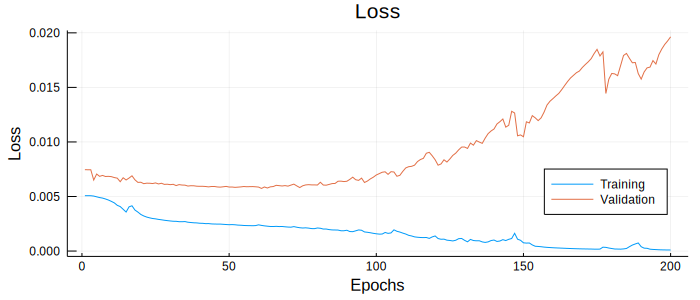

In [0]:
# Plot training and validation losses
plot([train_losses, val_losses], title="Loss", xlabel="Epochs", ylabel="Loss", label = ["Training" "Validation" ],  size = (700, 300),legend=:bottomright)
#plot(train_losses, title="Loss", xlabel="Epochs", ylabel="Loss",  size = (700, 300),legend=:topright)


In [0]:
# Find best validation
minLoss = findmin(val_losses)[1]
minEpoch = findmin(val_losses)[2]
println("Best validation loss of $minLoss occurred at epoch $minEpoch")

Best validation loss of 0.005739489 occurred at epoch 61


## 5.5 Final Accuracy

*Provide the final accuracy on the training, validation, and test set.*

In [0]:
function accuracyBatch(xdata, ydata)
  Flux.testmode!(classifier)
    c = 0
    n = 0
    for batch in 1:length(xdata)
      xbatch = xdata[batch]
      n_words = size(xbatch)[3]
      Flux.reset!(accumulator)
      for w in 1:n_words-1
          accumulator(xbatch[:,:,w])
      end
      output = (classifier(accumulator(xbatch[:,:,n_words]))).data
      predicted = []
      for x in 1:size(output)[2]
          predicted = findmax(output[:,x])[2]
          actual = findmax(ydata[batch][:,x])[2]
          if predicted == actual
              c += 1
          end
          n += 1
      end
    end
    return (c/n)*100
end

accuracyBatch (generic function with 1 method)

In [0]:
println("Validation accuracy: ", accuracyBatch(cpu.(val_xs), cpu.(val_ys)))
println("Test accuracy: ", accuracyBatch(cpu.(test_xs), cpu.(test_ys)))
println("Train accuracy: ", accuracyBatch(cpu.(train_xs), cpu.(train_ys)))

Validation accuracy: 41.507720254314265
Test accuracy: 41.40271493212669
Train accuracy: 47.12078651685393


## 5.6 Sample classifications

*Provide a selection of the classification decisions of the final model for 5 opinionated sentences from movies reviews that you find online – perhaps for a movie you liked, or did not like? Remember to provide a links to the reviews from which you selected the sentences.*

Five sentences have been chosen from the internet - three from Rotten Tomatoes' list *Top 100 Movies of All Time*, and two bad from Wikipedia's list *List of films considered the worst*.

**Dunkirk**
"One of the most captivating and compelling films of the year so far."<br/>https://www.rottentomatoes.com/m/dunkirk_2017

**Mad Max: Fury Road**: "Arty, gorgeous, exciting, compelling, and poignant all at once."<br/>https://www.rottentomatoes.com/m/mad_max_fury_road/

**Thor: Ragnarok:**
"A great film that will definitely entertain you and keep a smile on your face."<br/>https://www.rottentomatoes.com/m/thor_ragnarok_2017

**Birdemic: Shock and Terror:**
"It is, truly, one of the worst films ever made"<br/>https://www.huffpost.com/entry/review-embirdemic-shock-a_b_491140

**Meet the Spartans**
"This was the worst movie I've ever seen, so bad that I hesitate to label it a 'movie' and thus reflect shame upon the entire medium of film."<br/>https://www.rottentomatoes.com/m/meet_the_spartans

In [0]:
# Predict a rating based on the embedded review
function predictedRating(review)
    n_words = size(review)[2]
    Flux.reset!(accumulator)
    for w in 1:n_words-1
        accumulator(review[:,w])
    end
    return findmax(classifier(accumulator(review[:,n_words])))[2]
end

# Print out a review
function printReview(review)
    for word in review
        print(word, " ")
    end
    println(" " )
end

printReview (generic function with 1 method)

In [0]:
dunkirk = ["One", "of", "the", "most", "captivating", "and", "compelling", "films", "of", "the", "year", "so", "far", "."]
madmax = ["Arty", ",", "gorgeous", ",", "exciting", ",", "compelling", ",", "and", "poignant", "all", "at", "once", "."]
thor = ["A", "great", "film", "that", "will", "definitely", "entertain", "you", "and", "keep", "a", "smile", "on", "your", "face", "."]
spartans = ["This", "was", "the", "worst", "movie", "I", "'ve", "ever", "seen", ",", "so", "bad", "that", "I", "hesitate", "to", "label", "it", "a", "'"," movie", "'", "and", "thus", "reflect", "shame", "upon", "the", "entire", "medium", "of", "film", "."]
santa = ["The", "plot", ",", "such", "as", "it", "is", ",", "proves", "it", "is", "possible", "to", "insult", "the", "intelligence", "of", "a", "three", "-", "year", "-", "old"]
names = ["Dunkirk", "Max Max: Fury Road", "Thor: Ragnarok", "Meet the Spartans", "Santa Claus Conquers the Martians"]
reviews = [dunkirk, madmax, thor, spartans, santa]

# Remove stopwords
sampleReviews = removeStopwords(reviews)

# Embed using word2vec
reviewsData = gpu.(generateDataBatch(sampleReviews,500))

# Predict rating: 
for i in 1:5
    println(" ")
    println(names[i], ": ")
    printReview(reviews[i])
    println("Predicted rating: ", predictedRating(reviewsData[1][:,i,:]))
end

1/1..  
 
Dunkirk: 
One of the most captivating and compelling films of the year so far .  
Predicted rating: 5
 
Max Max: Fury Road: 
Arty , gorgeous , exciting , compelling , and poignant all at once .  
Predicted rating: 5
 
Thor: Ragnarok: 
A great film that will definitely entertain you and keep a smile on your face .  
Predicted rating: 4
 
Meet the Spartans: 
This was the worst movie I 've ever seen , so bad that I hesitate to label it a '  movie ' and thus reflect shame upon the entire medium of film .  
Predicted rating: 1
 
Santa Claus Conquers the Martians: 
The plot , such as it is , proves it is possible to insult the intelligence of a three - year - old  
Predicted rating: 2
